In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import boxcox
from sklearn.cluster import KMeans
from prettytable import PrettyTable
from scipy.stats import pointbiserialr

In [95]:
raw_df = pd.read_csv('./Data/deal_add_all_below_10.cs')

In [96]:
# 编码
deliver_way_dict = {'当日': 1, '一级': 2, '二级': 3, '标准级': 4}
category_dict = {'办公用品': 1, '技术':2, '家具': 3}
type_dict = {'消费者':0, '小型企业':1, '公司':2 }

sub_category_dict = {}
item_set = set()
for item in raw_df['sub_category']:
    if item not in item_set:
        sub_category_dict[item] = len(item_set) + 1
        item_set.add(item)

brand_dict = {}
item_set = set()
for item in raw_df['brand']:
    if item not in item_set:
        brand_dict[item] = len(item_set) + 1
        item_set.add(item)
        
area_dict = {
    '华北': 1,
    '东北': 2,
    '华东': 3, 
    '中南': 3, 
    '西南': 5, 
    '西北': 6
}

location_dict = {'华北': {},'东北': {},'华东': {},'中南': {}, '西南': {}, '西北': {}}

for i in range(len(raw_df['name'])):
    area = raw_df['user_area'][i]
    province = raw_df['user_province'][i]
    city = raw_df['user_city'][i]
    if province not in location_dict[area].keys():
        location_dict[area][province] = {}
    location_dict[area][province][city] = 0

province_dict = {}
city_dict = {}

for key in location_dict.keys():
    p_dict = location_dict[key]
    count = 0
    for province in p_dict.keys():
        province_dict[province] = eval(str(area_dict[key]) + str(count))
        count += 1
    for province in p_dict.keys():
        c_dict = location_dict[key][province]
        count = 0
        for city in c_dict.keys():
            if count < 10:
                cnt_str = str('00') + str(count)
            elif count < 100:
                cnt_str = str('0') + str(count)
            city_dict[city] = eval(str(area_dict[key]) + str(province_dict[province]) + cnt_str)
            count += 1

In [97]:
def get_df(raw_df):
    num_df = {}
    for key in raw_df.keys():
        if key != 'label' and key != 'name':
            num_df[key] = []
    for i in range(len(raw_df['name'])):
        num_df['brand'].append(brand_dict[raw_df['brand'][i]])
        num_df['days'].append(raw_df['days'][i])
        num_df['deliver_way'].append(deliver_way_dict[raw_df['deliver_way'][i]])
        num_df['discount'].append(raw_df['discount'][i])
        num_df['category'].append(category_dict[raw_df['category'][i]])
        num_df['sub_category'].append(sub_category_dict[raw_df['sub_category'][i]])
        num_df['price'].append(raw_df['price'][i])
        num_df['user_type'].append(type_dict[raw_df['user_type'][i]])
        num_df['user_city'].append(city_dict[raw_df['user_city'][i]])
        num_df['user_province'].append(province_dict[raw_df['user_province'][i]])
        num_df['user_area'].append(area_dict[raw_df['user_area'][i]])
        num_df['profit'].append(raw_df['profit'][i])
        num_df['sell_num'].append(raw_df['sell_num'][i])
    return num_df

In [98]:
def get_feature(raw_df):
    features = []
    labels = []
    for i in range(len(raw_df['name'])):
        feature = []
        feature.append(brand_dict[raw_df['brand'][i]])
        feature.append(raw_df['days'][i])
        feature.append(deliver_way_dict[raw_df['deliver_way'][i]])
        feature.append(raw_df['discount'][i])
        feature.append(category_dict[raw_df['category'][i]])
        feature.append(sub_category_dict[raw_df['sub_category'][i]])
        feature.append(raw_df['price'][i])
        feature.append(type_dict[raw_df['user_type'][i]])
        feature.append(city_dict[raw_df['user_city'][i]])
        feature.append(province_dict[raw_df['user_province'][i]])
        feature.append(area_dict[raw_df['user_area'][i]])
        feature.append(raw_df['profit'][i])
        feature.append(raw_df['sell_num'][i])
        
        features.append(feature)
        labels.append(raw_df['label'][i])
    
    return features,labels

In [99]:
features,labels = get_feature(raw_df)

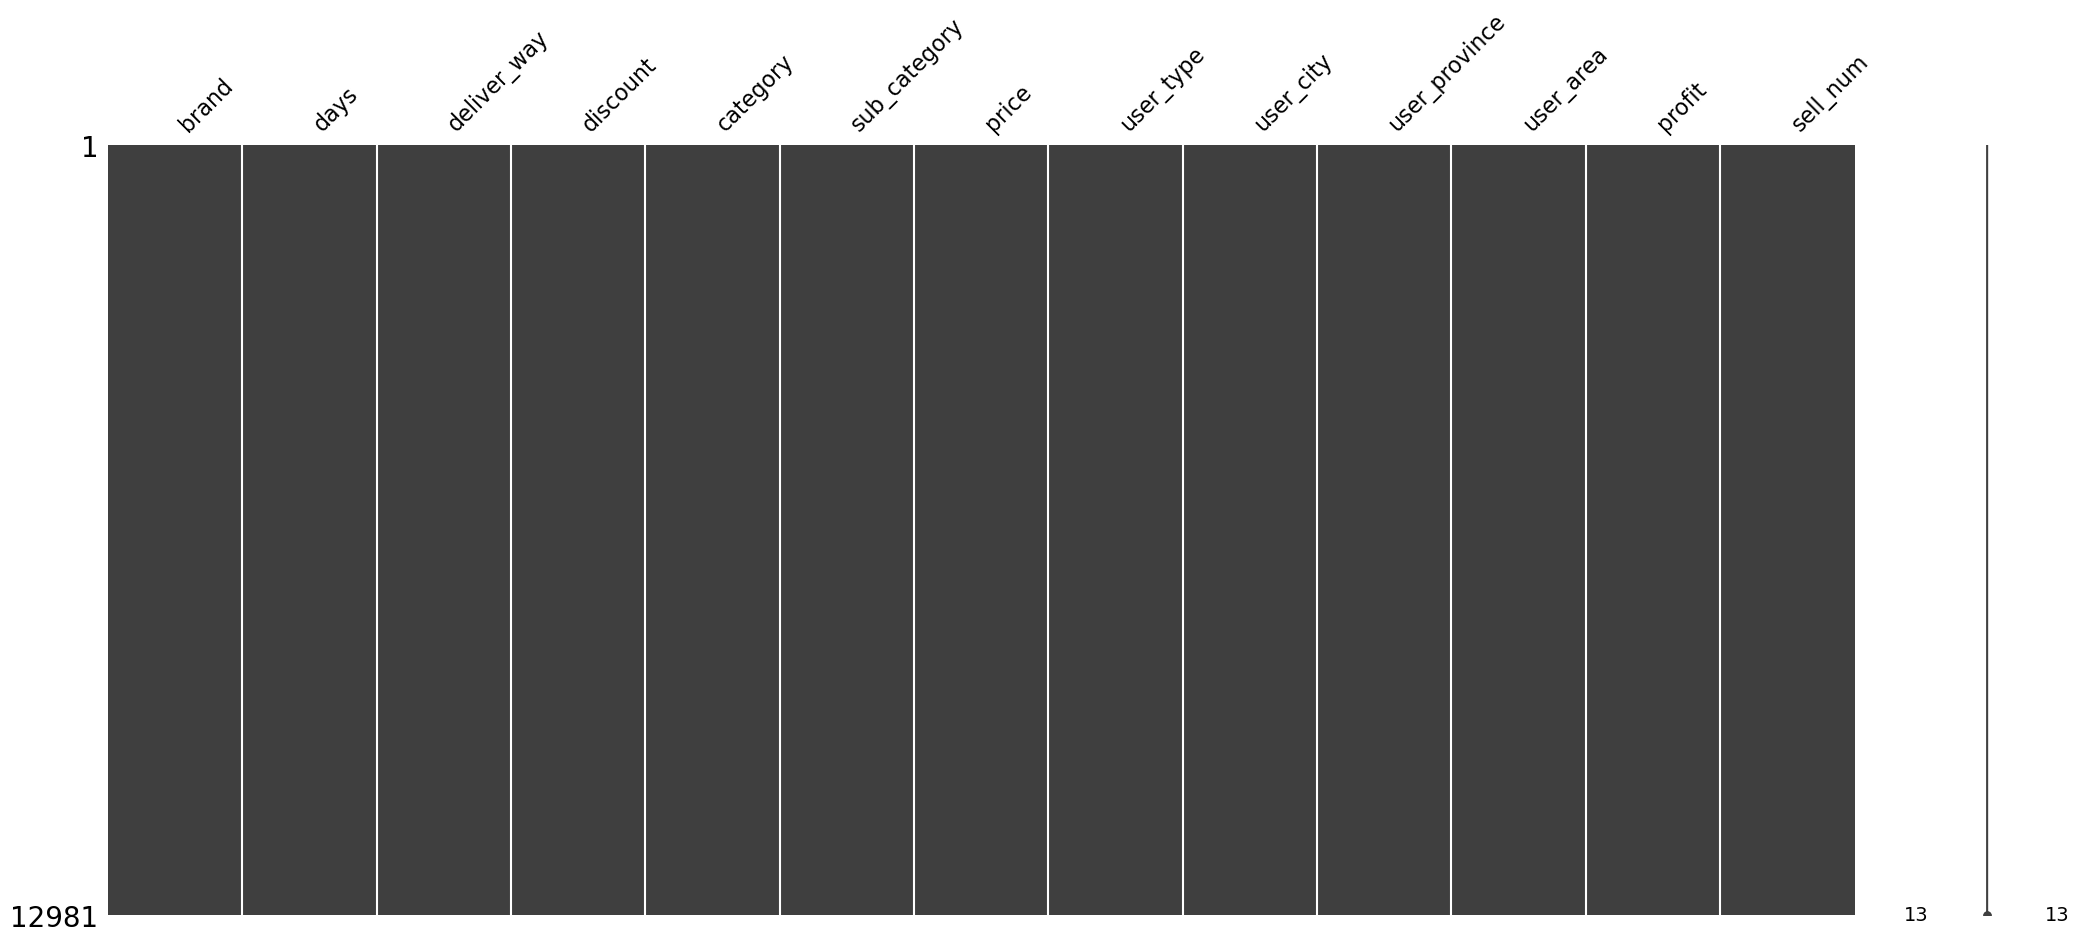

In [100]:
# 缺失值矩阵
df = pd.DataFrame(data=get_df(raw_df))
msno.matrix(df)
plt.show()

/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

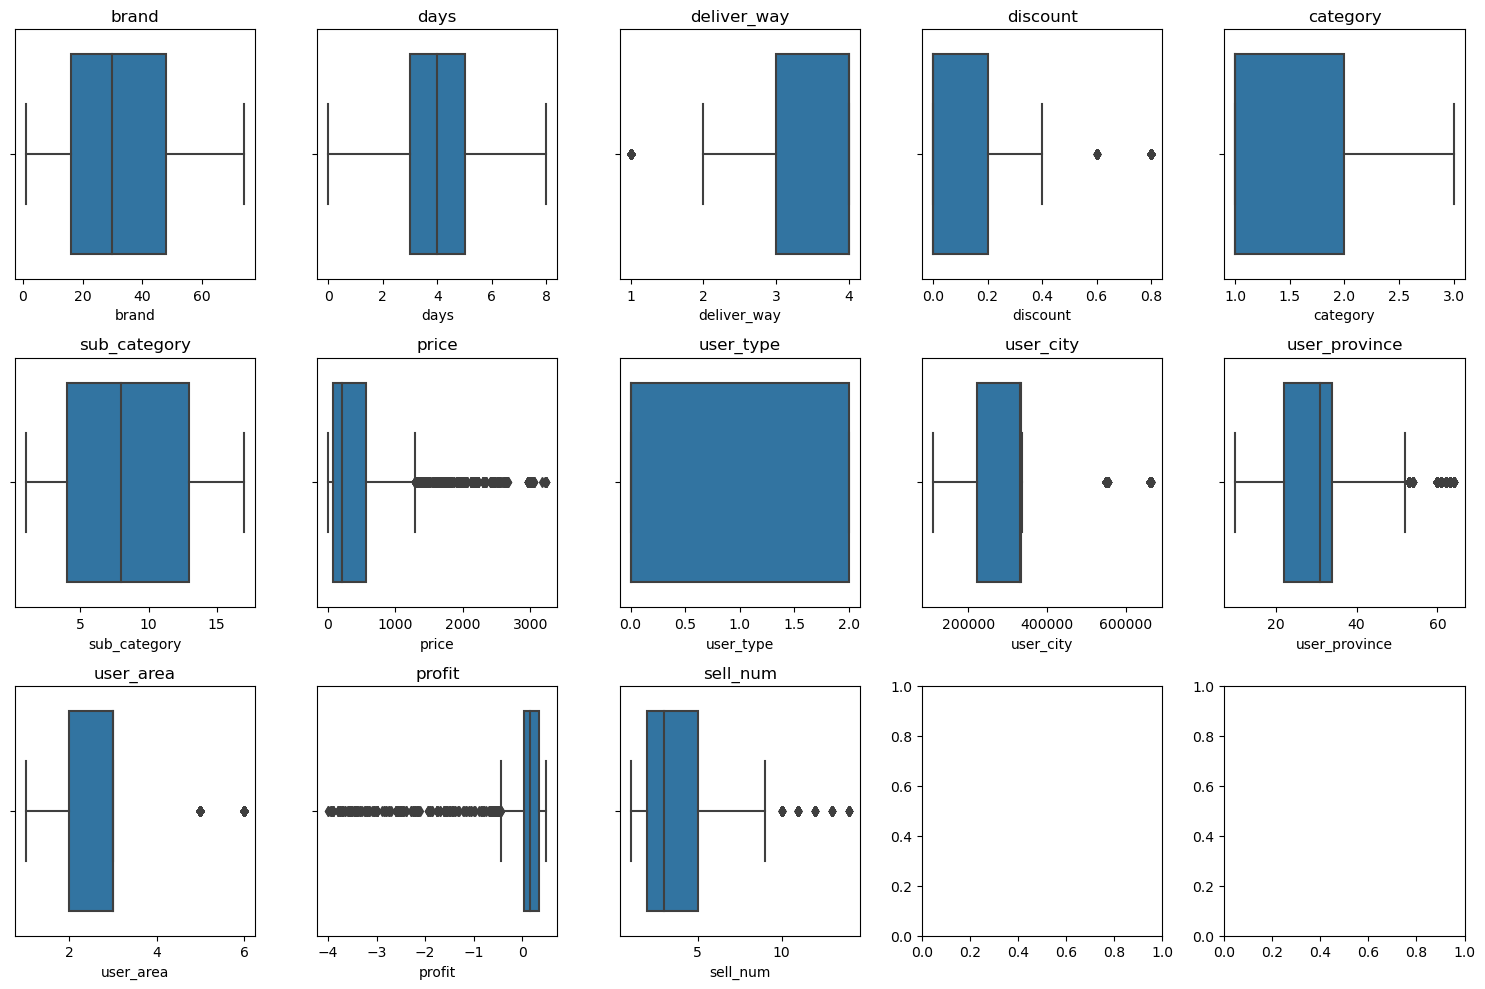

In [101]:
# 绘制特征箱线图
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

for i, column in enumerate(df.columns):
    sns.boxplot(x=df[column], ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)

plt.tight_layout()
plt.show()

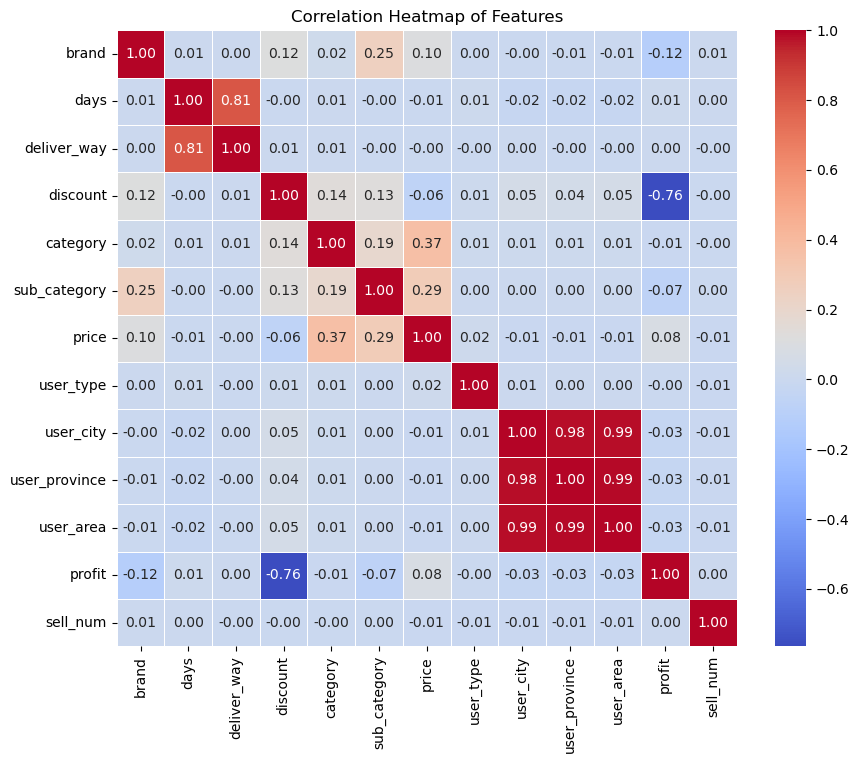

In [102]:
# 热度图绘制，寻找高度相关的特征
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

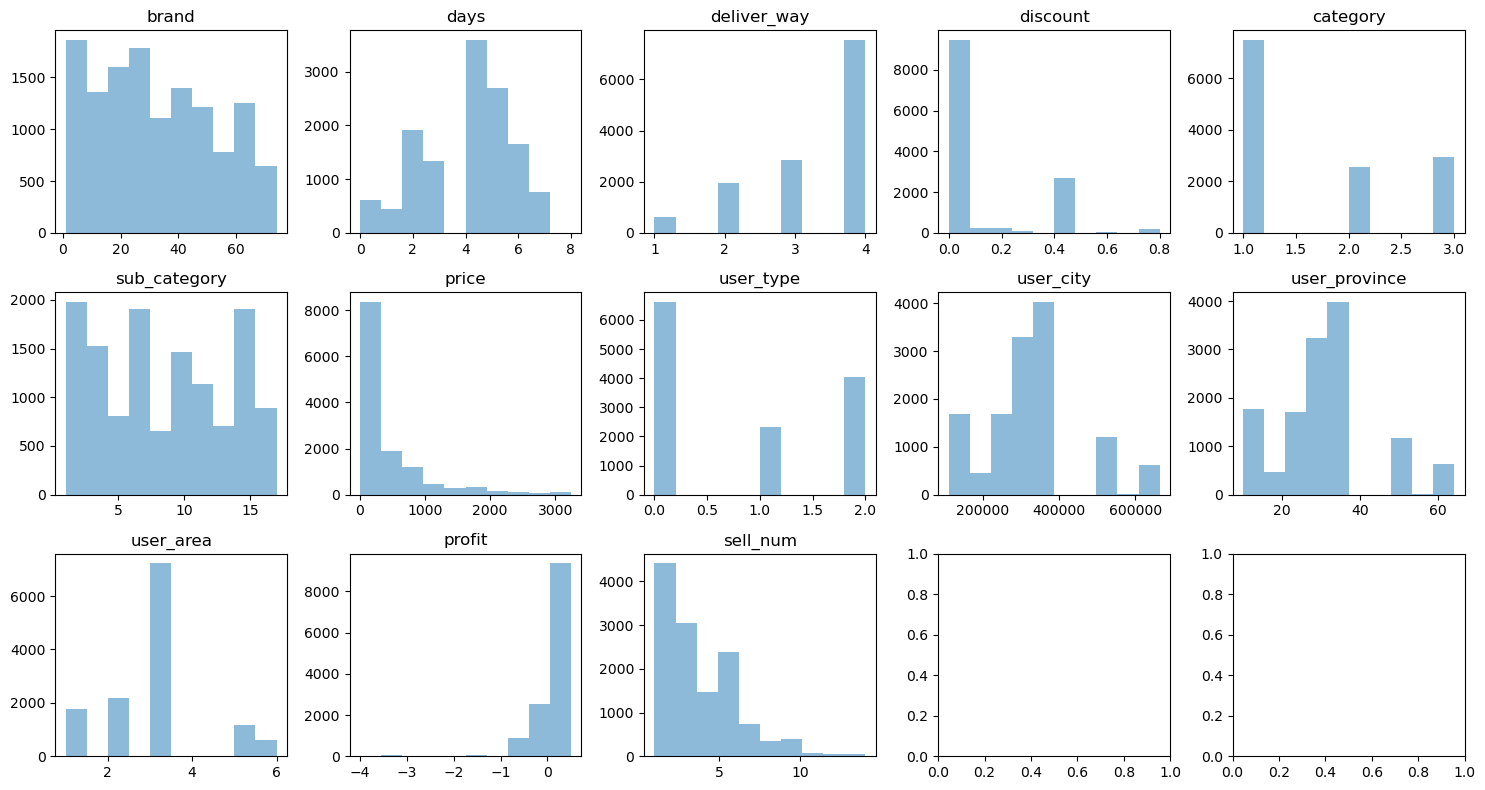

In [103]:
# 绘制特征分布图
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

for i, column in enumerate(df.columns):
    row, col = divmod(i, 5)
    axes[row, col].hist(df[column], bins=10, alpha=0.5)
    axes[row, col].set_title(column)

plt.tight_layout()
plt.show()

/Users/suzyyy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

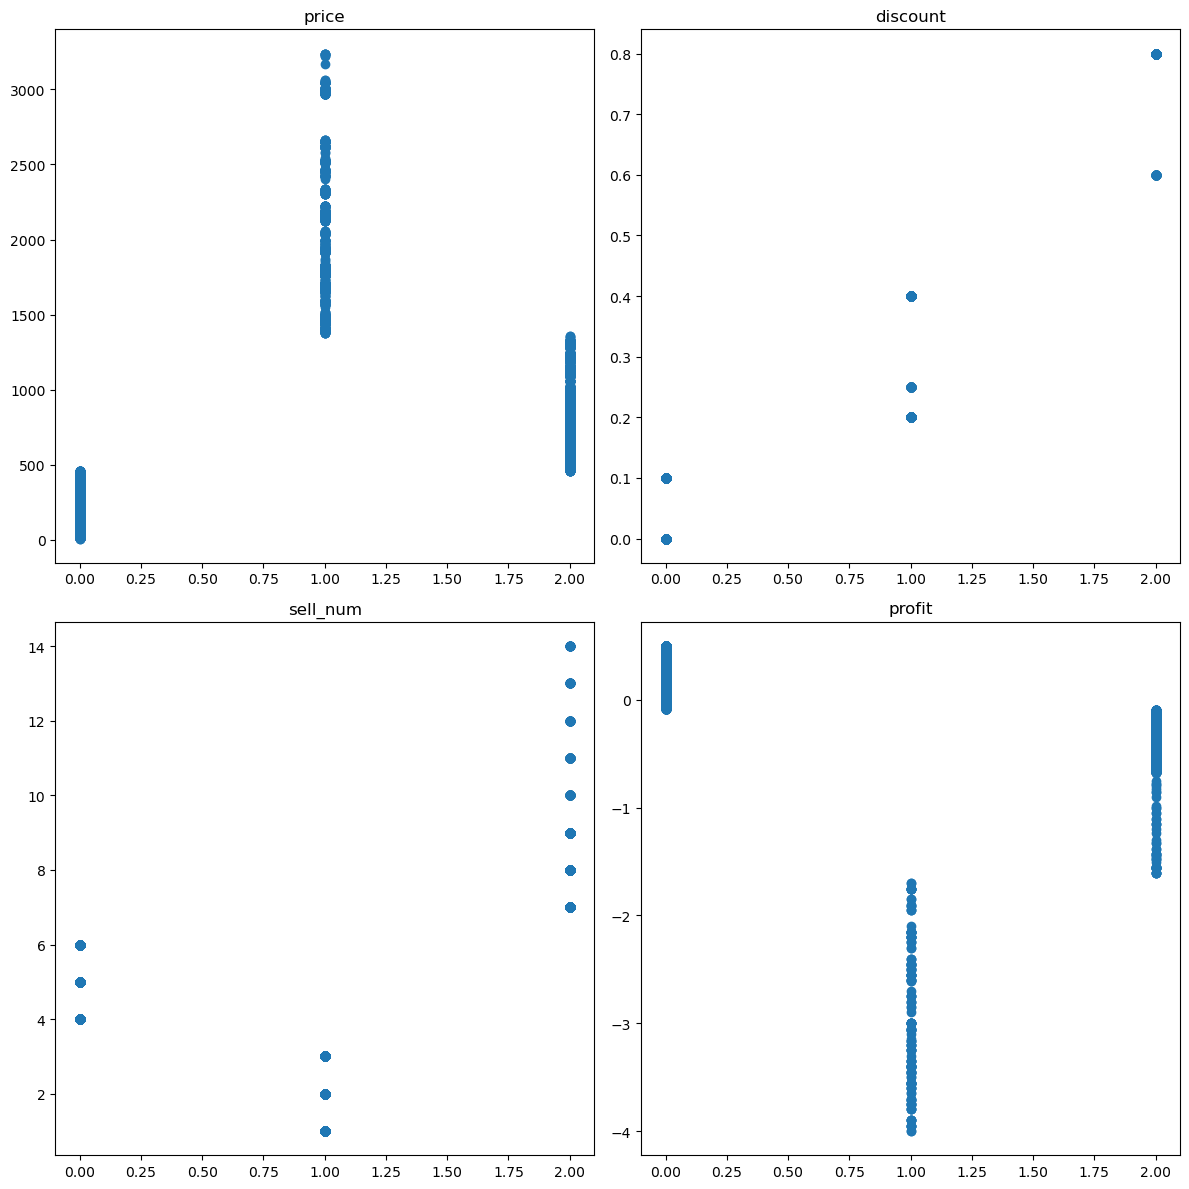

+-----------+-------+-----------------------+-----------------------+-----------------------+
| parameter | total |           0           |           1           |           2           |
+-----------+-------+-----------------------+-----------------------+-----------------------+
|   price   | 12981 | [151.42592388](71.2%) | [1989.20473545](7.7%) | [766.02339972](21.1%) |
|  discount | 12981 |  [0.00258124](74.9%)  |  [0.37951366](23.1%)  |   [0.74980392](2.0%)  |
|  sell_num | 12981 |  [4.81973582](29.7%)  |  [2.23535719](57.5%)  |  [8.27004219](12.8%)  |
|   profit  | 12981 |   [0.2299824](83.2%)  |  [-2.92222857](1.3%)  |  [-0.39367976](15.5%) |
+-----------+-------+-----------------------+-----------------------+-----------------------+


In [104]:
# 离散化
n_clusters=3

boundary={}
cluster_table=PrettyTable()
labels=["parameter", "total"]
labels.extend([i for i in range(n_clusters)])
cluster_table.field_names = labels
param_distribute_list = ['price','discount','sell_num','profit']
kmeans_result = []

fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(12,12))

for i in range(4):
    row=i//2
    col=i%2
    ax=axs[row][col]
    param=param_distribute_list[i]
    temp=np.array(df[param].values.reshape(-1, 1)).reshape(-1,1)
    kmeans=KMeans(n_clusters=n_clusters).fit(temp)
    result=kmeans.predict(temp)
    kmeans_result.append(result)
    counts=np.bincount(kmeans.labels_) 
    centers=kmeans.cluster_centers_
    boundary[param]=[item[0] for item in centers]
    boundary[param].sort()
    total=sum(counts)
    row=[param,total]
    for j in range(len(counts)):
        row.append('{}({}%)'.format(centers[j],round(counts[j]/total*100,1)))
    cluster_table.add_row(row)
    ax.scatter(result,temp)
    ax.set_title(param)
plt.tight_layout()
plt.show()

print(cluster_table)

In [105]:
# 整理处理结果
'price','discount','sell_num','profit'
processed_dict = {'brand':[], 'days':[],  'discount':[], 'category':[], 'sub_category':[],'price':[],
                  'user_type':[], 'user_city':[], 'profit':[],'sell_num':[],
                 'label':[]}

for i in range(len(raw_df['name'])):
    processed_dict['brand'].append(brand_dict[raw_df['brand'][i]])
    processed_dict['days'].append(raw_df['days'][i])
    processed_dict['discount'].append(kmeans_result[1][i])
    processed_dict['category'].append(category_dict[raw_df['category'][i]])
    processed_dict['sub_category'].append(sub_category_dict[raw_df['sub_category'][i]])
    processed_dict['price'].append(kmeans_result[0][i])
    processed_dict['user_type'].append(type_dict[raw_df['user_type'][i]])
    processed_dict['user_city'].append(city_dict[raw_df['user_city'][i]])
    processed_dict['profit'].append(kmeans_result[3][i])
    processed_dict['sell_num'].append(kmeans_result[2][i])
    processed_dict['label'].append(raw_df['label'][i])

In [106]:
# 检验
table = PrettyTable()
table.field_names = ["Feature", "Point Biserial Correlation", "P-value"]

label = processed_dict['label']

# 遍历特征列
for feature_name, feature_values in processed_dict.items():
    if feature_name != 'label':
        correlation, p_value = pointbiserialr(label, feature_values)
        table.add_row([feature_name, correlation, p_value])

# 打印 PrettyTable
print(table)

+--------------+----------------------------+------------------------+
|   Feature    | Point Biserial Correlation |        P-value         |
+--------------+----------------------------+------------------------+
|    brand     |    0.07836280581330057     | 3.8533602613122634e-19 |
|     days     |    0.003205906141294222    |   0.7149411528378438   |
|   discount   |     0.0321717489489962     | 0.0002463179554960528  |
|   category   |    0.004709903291618205    |   0.5915644476425456   |
| sub_category |    0.05185143676018337     |  3.39915556405694e-09  |
|    price     |    0.006015043622875374    |   0.493180287566644    |
|  user_type   |   -0.006260517542520444    |  0.47570635013962714   |
|  user_city   |    0.006734610615150866    |   0.442940484140803    |
|    profit    |    0.021959150673306185    |  0.012350829443754721  |
|   sell_num   |   -0.014060017236279103    |  0.10919064049605347   |
+--------------+----------------------------+------------------------+


In [108]:
df = pd.DataFrame(data=processed_dict)
df.to_csv('./Data/processed_feature_below_10.csv',index=None)

In [107]:
df

,brand,days,deliver_way,discount,category,sub_category,price,user_type,user_city,user_province,user_area,profit,sell_num
0,1,4,4,0.4,1,1,137.000000,0,330000,30,3,0.05,2
1,2,4,3,0.0,1,2,102.500000,0,330000,30,3,0.25,5
2,3,5,4,0.0,1,3,233.000000,0,331000,31,3,0.33,3
3,4,7,4,0.0,2,4,1196.333333,2,332000,32,3,0.05,1
4,5,3,2,0.0,3,5,88.000000,2,332000,32,3,0.15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12976,4,5,4,0.4,2,4,314.666667,0,332014,32,3,-0.33,3
12977,6,5,4,0.0,1,6,224.000000,0,332014,32,3,0.08,2
12978,62,5,4,0.4,3,14,240.000000,0,332014,32,3,-0.37,1
12979,51,5,4,0.4,2,4,693.142857,0,332014,32,3,-0.33,7
